In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sp
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler


from Modules.Feature_Extraction import *

In [3]:
def read_csv(filepath):
    signals = pd.read_csv(filepath, sep=',', header=None)

    return signals.to_numpy()


ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.csv')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.csv')


# fs = read_csv('Preprocessed_data/fs/fs.csv')
fs  = [62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725]

In [4]:
# # ffill along axis 1
# def ffill(arr):
#     mask = np.isnan(arr)
#     idx = np.where(~mask, np.arange(mask.shape[1]), 0)
#     np.maximum.accumulate(idx, axis=1, out=idx)
#     out = arr[np.arange(idx.shape[0])[:,None], idx]
#     return out
#
# ecg = ffill(ecg)
# ecg_filt = ffill(ecg_filt)

In [5]:
ecg_filt_cropped = []
for i in range(len(ecg_filt)):
    ecg_filt_cropped.append(ecg_filt[i][5000:763000])

ecg_cropped = []
for i in range(len(ecg)):
    ecg_cropped.append(ecg[i][5000:763000])

In [6]:
timestamp = np.arange(0, len(ecg_filt_cropped[0]))/fs[0]
test1 = pd.DataFrame(ecg_filt_cropped, columns=timestamp)

test1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0.000000,-0.024104,-0.001857,0.000745,-0.042702,-0.079504,0.112053,-0.034253,-0.005637,0.320509,-0.191313,-0.034978,-0.007852,-0.032851,0.067363,0.000680,0.070904,0.508759,0.091505,-0.091564,-0.036471
0.016007,-0.109793,0.030511,-0.013218,0.020541,-0.061022,0.133127,-0.039590,0.033148,0.238308,-0.173060,-0.035043,-0.271522,-0.004436,0.044870,0.000725,0.105573,0.414164,0.083053,-0.083595,-0.025521
0.032014,-0.130545,0.069127,-0.029724,0.062039,-0.032884,0.108753,-0.033383,0.073368,0.119495,-0.045145,-0.026062,-0.387175,0.035575,0.027015,0.003370,0.073002,0.205431,0.070054,-0.032662,-0.040361
0.048021,-0.098766,0.078870,-0.040402,0.055502,-0.025782,0.045315,-0.026243,0.088475,0.021024,0.134703,-0.009559,-0.350152,0.069325,0.016170,0.005360,-0.011414,-0.008644,0.072925,0.013601,-0.059418
0.064028,-0.051949,0.038704,-0.045545,0.004934,-0.056398,-0.022906,-0.024930,0.060125,-0.014058,0.271211,0.003225,-0.241247,0.084217,0.011707,0.008636,-0.090654,-0.135323,0.098686,-0.003069,-0.062032


In [18]:
from sklearn.model_selection import train_test_split

TIME_STEPS = 1000

# Generated training sequences for use in the model.
def create_sequences(data, time_steps=TIME_STEPS):
    output = []
    for patient in range(0,len(data)):
        values = data[patient]
        for i in range(0,len(values) - time_steps + 1, 500):
            output.append(values[i : (i + time_steps)])

    return np.stack(output)


x_train = create_sequences(test1.values)
x_train, x_test = train_test_split(x_train, test_size=0.2, shuffle=False)
x_test, x_val = train_test_split(x_test, test_size=0.5, shuffle=True)

In [19]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
# x_train = data_scaled.transform(x_train)
# x_test = data_scaled.transform(x_test)
# x_val = data_scaled.transform(x_val)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1], 1)

print("Training input shape: ", x_train.shape)
print("Test input shape: ", x_test.shape)
print("Val input shape: ", x_val.shape)

Training input shape:  (24240, 1000, 1)
Test input shape:  (3030, 1000, 1)
Val input shape:  (3030, 1000, 1)


In [20]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="mae")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 500, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 500, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 250, 16)           3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 500, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 500, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 1000, 32)         3616      
 ranspose)                                            

In [21]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    validation_data = (x_val, x_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    ],
)

Epoch 1/50
95/95 [==============================] - 37s 352ms/step - loss: 0.0490 - val_loss: 0.0090
Epoch 2/50
95/95 [==============================] - 37s 385ms/step - loss: 0.0190 - val_loss: 0.0055
Epoch 3/50
95/95 [==============================] - 34s 354ms/step - loss: 0.0160 - val_loss: 0.0049
Epoch 4/50
95/95 [==============================] - 32s 337ms/step - loss: 0.0143 - val_loss: 0.0057
Epoch 5/50
95/95 [==============================] - 27s 288ms/step - loss: 0.0129 - val_loss: 0.0081


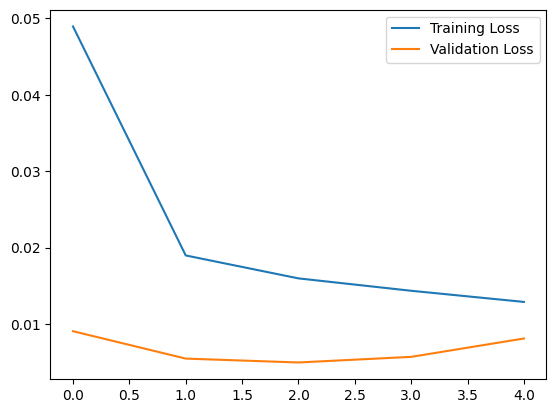

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

758/758 [==============================] - 10s 13ms/step


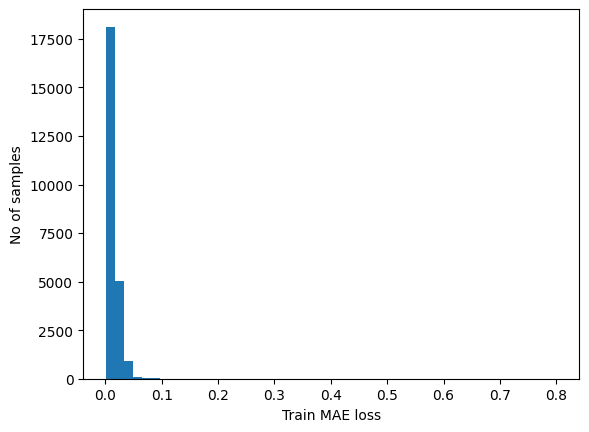

Reconstruction error threshold:  0.8005721468964873


In [23]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

95/95 [==============================] - 1s 11ms/step


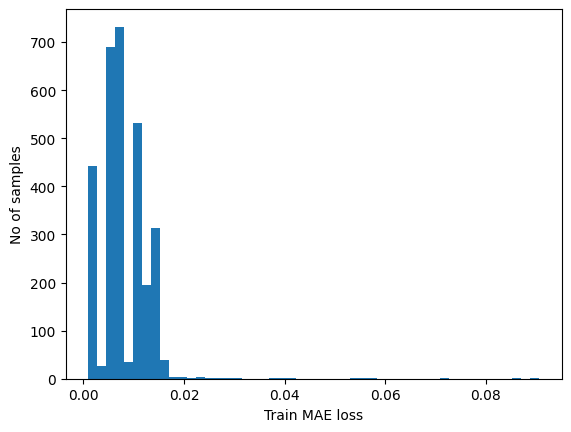

Reconstruction error threshold:  0.09055223696507148


In [24]:
x_test_pred = model.predict(x_test)
train_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

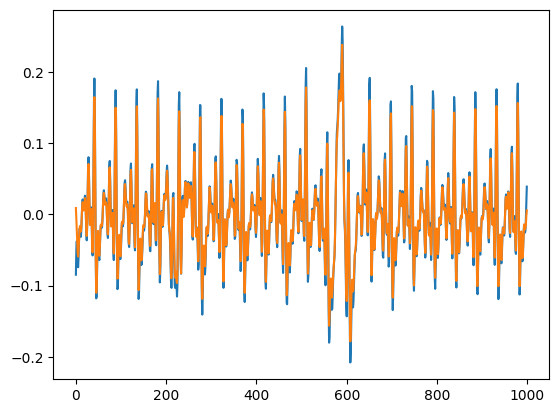

In [25]:
# Checking how the first sequence is learnt
plt.plot(x_test[10])
plt.plot(x_test_pred[10])
plt.show()

In [26]:
anomoly_test = []
anomoly_test_pred = []

for i in range(len(train_mae_loss)):
    if train_mae_loss[i] > 0.05:
        anomoly_test.append(x_test[i])
        anomoly_test_pred.append(x_test_pred[i])

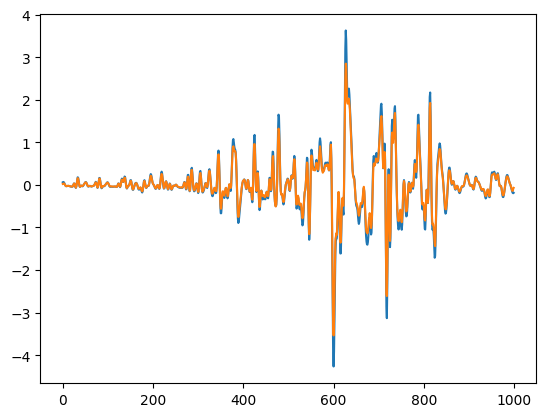

In [31]:
# Checking how the first sequence is learnt
plt.plot(anomoly_test[4])
#plt.plot(anomoly_test_pred[4])
plt.show()

In [37]:
# lstm autoencoder predict sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model


# define model
model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(x_train.shape[1],1)))
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(5, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=512,
    validation_data = (x_val, x_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    ],
)

# demonstrate recreation
#yhat = model.predict(sequence, verbose=0)




Epoch 1/10
48/48 [==============================] - 43s 844ms/step - loss: 0.0692 - val_loss: 0.0208
Epoch 2/10
48/48 [==============================] - 45s 950ms/step - loss: 0.0692 - val_loss: 0.0208
Epoch 3/10
48/48 [==============================] - 42s 877ms/step - loss: 0.0691 - val_loss: 0.0208
Epoch 4/10
48/48 [==============================] - 40s 841ms/step - loss: 0.0691 - val_loss: 0.0208
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


95/95 [==============================] - 8s 82ms/step


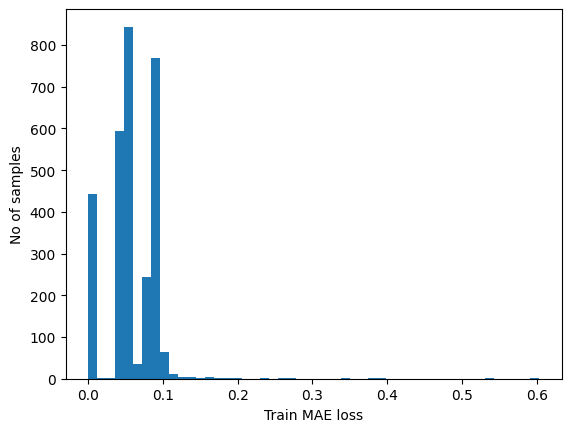

Reconstruction error threshold:  0.6027576035799095


In [43]:
x_test_pred = model.predict(x_test)
train_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

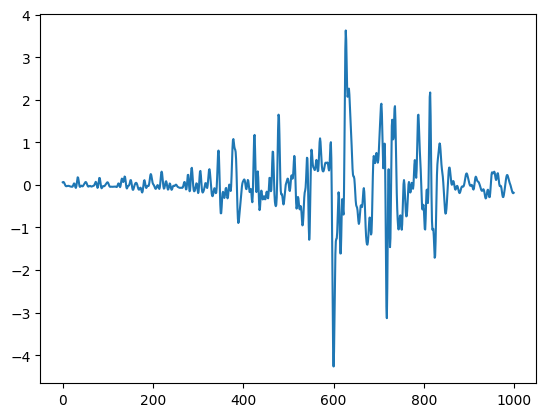

In [47]:
anomoly_test = []
anomoly_test_pred = []

for i in range(len(train_mae_loss)):
    if train_mae_loss[i] > 0.3:
        anomoly_test.append(x_test[i])
        anomoly_test_pred.append(x_test_pred[i])
# Checking how the first sequence is learnt
plt.plot(anomoly_test[4])
plt.show()

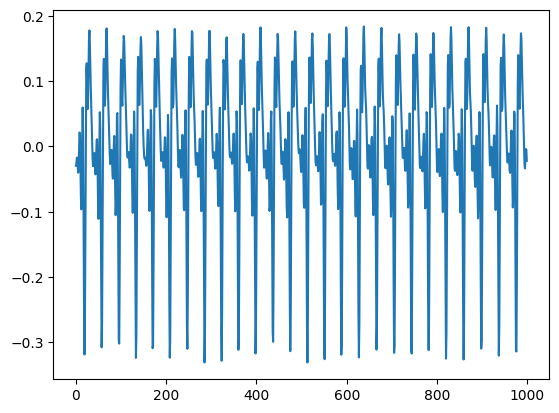

In [46]:
plt.plot(x_test[1])
plt.show()